In [51]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time

# --- Constantes ---
MOVIMIENTOS = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # N, E, S, O
NORTE, ESTE, SUR, OESTE = 0, 1, 2, 3

In [52]:
# --- Lectura del laberinto ---
def lectura(file_path):
    maze = []
    start = end = None
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            row = []
            for j, val in enumerate(line.strip().split()):
                if val == '1': row.append(1)
                elif val == '0': row.append(0)
                elif val.upper() == 'S':
                    row.append(0)
                    start = (i, j)
                elif val.upper() == 'E':
                    row.append(0)
                    end = (i, j)
                else:
                    raise ValueError(f"Valor inesperado en ({i},{j}): {val}")
            maze.append(row)
    if start is None or end is None:
        raise ValueError("El archivo debe contener 'S' y 'E'")
    return np.array(maze), start, end

In [53]:
# --- Simular ejecución ---
def simular_ruta(individual, maze, start, end, max_steps=2000):
    pos = start
    pasos = 0
    colisiones = 0
    visitados = {pos: 1}
    min_dist = abs(start[0] - end[0]) + abs(start[1] - end[1])
    pasos_hasta_llegar = 0
    for i, move in enumerate(individual[:max_steps]):
        if pos == end:
            if pasos_hasta_llegar == 0:
                pasos_hasta_llegar = pasos
            break
        dy, dx = MOVIMIENTOS[move]
        nueva_pos = (pos[0] + dy, pos[1] + dx)
        if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
            pos = nueva_pos
            pasos += 1
            visitados[pos] = visitados.get(pos, 0) + 1
            dist = abs(pos[0] - end[0]) + abs(pos[1] - end[1])
            min_dist = min(min_dist, dist)
        else:
            colisiones += 1
    llego = (pos == end)
    rep = sum((v - 1) for v in visitados.values() if v > 1)
    return pasos, colisiones, llego, pos, rep, min_dist, pasos_hasta_llegar

In [54]:
def fitness_ruta(individual, maze, start, end):
    pasos, colisiones, llego, pos, rep, min_dist, pasos_hasta_llegar = simular_ruta(individual, maze, start, end)
    dist = abs(pos[0] - end[0]) + abs(pos[1] - end[1])
    dist_inicial = abs(start[0] - end[0]) + abs(start[1] - end[1])
    
    # Penalizaciones
    score = -pasos - 2*colisiones - 2*dist - 5*rep

    # Bonificación por acercarse en cualquier momento
    score += 3 * (dist_inicial - min_dist)

    # Penalización por retrocesos
    pos_actual = start
    retrocesos = 0
    for move in individual:
        if pos_actual == end:
            break
        dy, dx = MOVIMIENTOS[move]
        nueva_pos = (pos_actual[0] + dy, pos_actual[1] + dx)
        if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
            dist_antes = abs(pos_actual[0] - end[0]) + abs(pos_actual[1] - end[1])
            dist_despues = abs(nueva_pos[0] - end[0]) + abs(nueva_pos[1] - end[1])
            if dist_despues > dist_antes:
                retrocesos += 1
            pos_actual = nueva_pos
    score -= 2 * retrocesos  # Penaliza cada retroceso

    # Bonificaciones graduales
    if dist < 50:
        score += 200
    if dist < 30:
        score += 400
    if dist < 15:
        score += 800
    if llego:
        score += 5000
    
    if pasos_hasta_llegar > 0:
        score += 1000 / pasos_hasta_llegar
    
    # Bonificación por reducción de distancia entre pasos consecutivos
    avance = dist_inicial - dist
    if avance > 0:
        score += avance * 2  # Ajusta el factor según lo que observes
    
    return score


In [55]:
def optimizar_ruta(individual, maze, start, end, max_steps=2000):
    ruta_optimizada = []
    pos = start
    visitados = {pos}
    i = 0
    while i < len(individual) and pos != end and i < max_steps:
        move = individual[i]
        dy, dx = MOVIMIENTOS[move]
        nueva_pos = (pos[0] + dy, pos[1] + dx)
        if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
            # Verificar si el movimiento es válido y no crea bucles
            if nueva_pos not in visitados or nueva_pos == end:
                ruta_optimizada.append(move)
                pos = nueva_pos
                visitados.add(pos)
            else:
                # Intentar un movimiento alternativo válido
                valid_moves = []
                for m in range(4):
                    ddy, ddx = MOVIMIENTOS[m]
                    next_pos = (pos[0] + ddy, pos[1] + ddx)
                    if (0 <= next_pos[0] < maze.shape[0] and 0 <= next_pos[1] < maze.shape[1] and maze[next_pos] == 0 and next_pos not in visitados):
                        valid_moves.append(m)
                if valid_moves:
                    move = random.choice(valid_moves)
                    ruta_optimizada.append(move)
                    pos = (pos[0] + MOVIMIENTOS[move][0], pos[1] + MOVIMIENTOS[move][1])
                    visitados.add(pos)
                else:
                    ruta_optimizada.append(move)  # Mantener movimiento si no hay alternativas
        else:
            # Omitir colisiones o intentar movimiento válido
            valid_moves = []
            for m in range(4):
                ddy, ddx = MOVIMIENTOS[m]
                next_pos = (pos[0] + ddy, pos[1] + ddx)
                if (0 <= next_pos[0] < maze.shape[0] and 0 <= next_pos[1] < maze.shape[1] and maze[next_pos] == 0 and next_pos not in visitados):
                    valid_moves.append(m)
            if valid_moves:
                move = random.choice(valid_moves)
                ruta_optimizada.append(move)
                pos = (pos[0] + MOVIMIENTOS[move][0], pos[1] + MOVIMIENTOS[move][1])
                visitados.add(pos)
            else:
                i += 1
                continue
        i += 1
    # Rellenar con movimientos aleatorios si es necesario
    while len(ruta_optimizada) < len(individual):
        ruta_optimizada.append(random.randint(0, 3))
    return ruta_optimizada


In [56]:
def generar_poblacion(size, ruta_length, start, end, completamente_aleatoria=False):
    pop = []
    for _ in range(size):
        ruta = []
        pos = start
        for _ in range(ruta_length):
            if completamente_aleatoria or random.random() < 0.7:
                ruta.append(random.randint(0, 3))
            else:
                valid_moves = []
                for move in range(4):
                    dy, dx = MOVIMIENTOS[move]
                    nueva_pos = (pos[0] + dy, pos[1] + dx)
                    if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
                        valid_moves.append(move)
                if valid_moves and random.random() < 0.8:
                    move = random.choice(valid_moves)
                else:
                    dx = end[1] - pos[1]
                    dy = end[0] - pos[0]
                    if abs(dx) > abs(dy):
                        move = ESTE if dx > 0 else OESTE
                    else:
                        move = SUR if dy > 0 else NORTE
                    if random.random() < 0.3:
                        move = random.randint(0, 3)
                ruta.append(move)
                dy, dx = MOVIMIENTOS[move]
                nueva_pos = (pos[0] + dy, pos[1] + dx)
                if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
                    pos = nueva_pos
        pop.append(ruta)
    return pop


In [57]:
def crossover_ruta(p1, p2):
    punto = random.randint(1, len(p1) - 1)
    return p1[:punto] + p2[punto:], p2[:punto] + p1[punto:]


In [58]:
def mutar_ruta(ind, tasa=0.15, maze=None, pos_inicial=None):
    pos = pos_inicial
    visitados = {pos} if pos_inicial else set()
    for i in range(len(ind)):
        if random.random() < tasa:
            if maze is not None and pos is not None and random.random() < 0.8:
                valid_moves = []
                for move in range(4):
                    dy, dx = MOVIMIENTOS[move]
                    nueva_pos = (pos[0] + dy, pos[1] + dx)
                    if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0 and nueva_pos not in visitados):
                        valid_moves.append(move)
                if valid_moves:
                    ind[i] = random.choice(valid_moves)
                else:
                    ind[i] = random.randint(0, 3)
            else:
                ind[i] = random.randint(0, 3)
        if maze is not None and pos is not None:
            dy, dx = MOVIMIENTOS[ind[i]]
            nueva_pos = (pos[0] + dy, pos[1] + dx)
            if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
                pos = nueva_pos
                visitados.add(pos)


In [59]:
def seleccion_torneo(pop, fitnesses, k=5):
    seleccionados = random.sample(range(len(pop)), k)
    return pop[max(seleccionados, key=lambda i: fitnesses[i])]


In [60]:

def evolucionar_rutas(pop, maze, start, end, gens=5000, mut_rate=0.2, tiempo_max=300):
    mejor = None
    mejor_fit = -float('inf')
    estancamiento_contador = 0
    mejor_dist = float('inf')
    start_time = time.time()

    for gen in range(gens):
        if time.time() - start_time > tiempo_max:
            print(f"\n⏰ Tiempo límite alcanzado ({tiempo_max}s). Terminando evolución.")
            break

        fitnesses = [fitness_ruta(ind, maze, start, end) for ind in pop]
        idx = np.argmax(fitnesses)

        _, _, llego, pos, _, min_dist, _ = simular_ruta(pop[idx], maze, start, end)
        dist = abs(pos[0] - end[0]) + abs(pos[1] - end[1])

        if fitnesses[idx] > mejor_fit or (fitnesses[idx] == mejor_fit and dist < mejor_dist):
            mejor = pop[idx][:]
            mejor_fit = fitnesses[idx]
            mejor_dist = dist
            estancamiento_contador = 0

            if llego:
                print(f"\n✅ ¡Solución encontrada en la generación {gen}!")
                print(f"Mejor fitness = {mejor_fit:.2f}")
                plt.figure(figsize=(10, 10))
                visualizar_trayectoria(maze, start, end, mejor)
                plt.savefig(f"solucion_final_gen_{gen}.png")
                plt.close()
                return mejor
        else:
            estancamiento_contador += 1

        tasa_mutacion_fuerte = min(0.3 + 0.02 * estancamiento_contador, 0.5)

        if estancamiento_contador >= 15:
            print(f"⚠️ Estancamiento en Gen {gen}: Mutación fuerte (tasa={tasa_mutacion_fuerte:.2f}) y repoblación")
            nueva_pop = [mejor]
            n_aleatorio = int(0.8 * (len(pop) - 1))
            n_heuristico = (len(pop) - 1) - n_aleatorio
            nueva_pop.extend(generar_poblacion(n_aleatorio, len(pop[0]), start, end, completamente_aleatoria=True))
            nueva_pop.extend(generar_poblacion(n_heuristico, len(pop[0]), start, end, completamente_aleatoria=False))
            pop = nueva_pop
            estancamiento_contador = 0
            continue

        if gen % 50 == 0 and gen > 0:
            pop[idx] = optimizar_ruta(pop[idx], maze, start, end)

        nueva_pop = [pop[idx][:]]
        if gen % 50 == 0 and gen > 0:
            nueva_pop += generar_poblacion(5, len(pop[0]), start, end)
            nueva_pop = nueva_pop[:len(pop)]

        while len(nueva_pop) < len(pop):
            p1 = seleccion_torneo(pop, fitnesses, k=5)
            p2 = seleccion_torneo(pop, fitnesses, k=5)
            h1, h2 = crossover_ruta(p1, p2)
            mutar_ruta(h1, mut_rate, maze, start)
            mutar_ruta(h2, mut_rate, maze, start)
            nueva_pop += [h1, h2][:len(pop) - len(nueva_pop)]
        pop = nueva_pop

        if gen % 100 == 0:
            print(f"Gen {gen:03}: Mejor fitness = {mejor_fit:.2f}")
            pasos, col, llego, pos, rep, min_dist, pasos_hasta_llegar = simular_ruta(mejor, maze, start, end)
            dist = abs(pos[0] - end[0]) + abs(pos[1] - end[1])
            print(f"Detalles: Pasos={pasos}, Colisiones={col}, Llegó={llego}, Posición={pos}, Repeticiones={rep}, Distancia={dist}, Min Distancia={min_dist}, Pasos hasta llegar={pasos_hasta_llegar}")
            plt.figure(figsize=(10, 10))
            plt.imshow(maze, cmap='binary')
            trayectoria = [start]
            pos = start
            for move in mejor:
                if pos == end:
                    break
                dy, dx = MOVIMIENTOS[move]
                nueva_pos = (pos[0] + dy, pos[1] + dx)
                if (0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0):
                    pos = nueva_pos
                    trayectoria.append(pos)
            ys, xs = zip(*trayectoria)
            plt.plot(xs, ys, 'r.-', linewidth=2)
            plt.plot(start[1], start[0], 'go', markersize=10, label='Inicio')
            plt.plot(end[1], end[0], 'b*', markersize=10, label='Fin')
            plt.title(f"Trayectoria del mejor individuo - Gen {gen}\nFitness: {mejor_fit:.2f}, Distancia: {dist}")
            plt.legend()
            plt.savefig(f"trayectoria_gen_{gen:04d}.png", dpi=300, bbox_inches='tight')
            plt.close()
        else:
            print(f"Gen {gen:03}: Mejor fitness = {mejor_fit:.2f}")

    print("\n🛑 Evolución terminada sin encontrar solución directa.")
    print("🔧 Aplicando optimización local sobre el mejor individuo encontrado...")
    mejor_opt = optimizar_ruta(mejor, maze, start, end)
    return mejor_opt


In [ ]:
def visualizar_trayectoria(maze, start, end, individuo):
    from matplotlib.patches import Rectangle

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, maze.shape[1])
    ax.set_ylim(maze.shape[0], 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            color = 'black' if maze[i, j] == 1 else 'white'
            ax.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='black'))

    pos = start
    for move in individuo:
        if pos == end:
            break
        dy, dx = MOVIMIENTOS[move]
        nueva_pos = (pos[0] + dy, pos[1] + dx)
        if 0 <= nueva_pos[0] < maze.shape[0] and 0 <= nueva_pos[1] < maze.shape[1] and maze[nueva_pos] == 0:
            pos = nueva_pos
            ax.add_patch(Rectangle((pos[1], pos[0]), 1, 1, facecolor='blue', edgecolor='black'))

    # Inicio y fin
    ax.add_patch(Rectangle((start[1], start[0]), 1, 1, facecolor='green', edgecolor='black'))
    ax.add_patch(Rectangle((end[1], end[0]), 1, 1, facecolor='red', edgecolor='black'))

    plt.title("Mejor individuo en el laberinto")
    plt.show()



Dimensiones del laberinto: (15, 15)
Inicio: (1, 0), Fin: (13, 14)
Distancia Manhattan inicial: 26

✅ ¡Solución encontrada en la generación 0!
Mejor fitness = 5382.10


<Figure size 1000x1000 with 0 Axes>

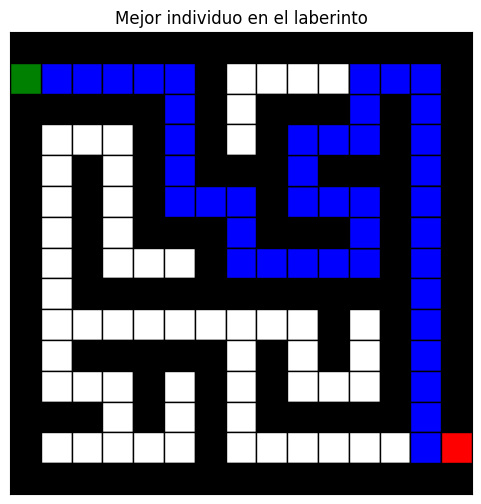


Mejor individuo encontrado:
Pasos: 164, Colisiones=121, Llegó=True, Posición final: (13, 14), Repeticiones: 122, Distancia: 0, Min Distancia: 0, Pasos hasta llegar: 164


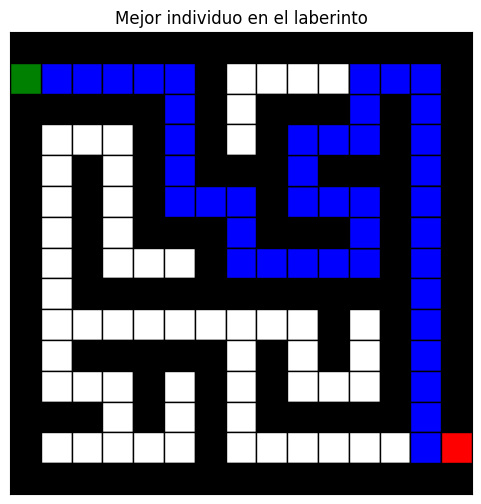

In [62]:
# --- Main ---
if __name__ == "__main__":
    archivo = "maze_case_base.txt"
    # archivo = "LAB6/maze_case_base.txt"

    maze, start, end = lectura(archivo)
    print(f"Dimensiones del laberinto: {maze.shape}")
    print(f"Inicio: {start}, Fin: {end}")
    dist_inicial = abs(start[0] - end[0]) + abs(start[1] - end[1])
    print(f"Distancia Manhattan inicial: {dist_inicial}")
    
    poblacion = generar_poblacion(500, 500, start, end)
    
    mejor = evolucionar_rutas(
        poblacion, 
        maze, 
        start, 
        end, 
        gens=5000, 
        mut_rate=0.2,
        tiempo_max=300
    )

    print("\nMejor individuo encontrado:")
    pasos, col, llego, pos, rep, min_dist, pasos_hasta_llegar = simular_ruta(mejor, maze, start, end, max_steps=2000)
    dist = abs(pos[0] - end[0]) + abs(pos[1] - end[1])
    print(f"Pasos: {pasos}, Colisiones={col}, Llegó={llego}, Posición final: {pos}, Repeticiones: {rep}, Distancia: {dist}, Min Distancia: {min_dist}, Pasos hasta llegar: {pasos_hasta_llegar}")
    visualizar_trayectoria(maze, start, end, mejor)